All people are beautiful. In this project word "beautiful" means "has high score in given dataset".

Dataset paper: <a href="https://arxiv.org/abs/1801.06345">SCUT-FBP5500: A Diverse Benchmark Dataset for Multi-Paradigm Facial Beauty Prediction</a>
        
Only female part of the dataset will be used for the sake of time and simplicity (no unique text prompts for m/f)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from tqdm.notebook import tqdm
from PIL import Image

E:\Code\envs\ml\lib\site-packages\clip\clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:
SPLIT_FILE_PATH = './data/train_test_files/train_test_split'
IMAGES_PATH = './data/images'

BEAUTY_THRESHOLD_VALUE = 3.25  # if mean score > threshold then the person is "beautiful"
DOT_PRODUCT_SCALE = 1.0

In [3]:
def read_scores(filename, datadict, skip_males=True):
    with open(os.path.join(SPLIT_FILE_PATH, filename), 'r') as file:
        for line in file:
            fname, score = line.split()
            if skip_males and fname[1] == 'M':
                continue
            datadict[fname] = float(score)

In [4]:
scores_test = {}
scores_train = {}

read_scores('test.txt', scores_test)
read_scores('train.txt', scores_train)

In [5]:
device = 'cpu' # "cuda" if torch.cuda.is_available() else "cpu"

# idea: compare resnet and vit
model, preprocess = clip.load("RN50", device=device)

In [6]:
text = clip.tokenize('a photo of a beautiful woman').to(device)

with torch.no_grad():
    text_features = model.encode_text(text)
print(text_features.shape)

torch.Size([1, 1024])


In [7]:
def read_and_extract_features(scores, X, y):
    for img, score in tqdm(scores.items()):
        y.append(score)
        img_path = os.path.join(IMAGES_PATH, img)
        img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model.encode_image(img)
        X.append(features)

In [8]:
# X - image features, y - mean score
X_train, X_test = [], []
y_train, y_test = [], []

read_and_extract_features(scores_train, X_train, y_train)


X_train = torch.cat(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

  0%|          | 0/1673 [00:00<?, ?it/s]

torch.Size([1673, 1024]) (1673,)


In [9]:
read_and_extract_features(scores_test, X_test, y_test)  

X_test = torch.cat(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

  0%|          | 0/1077 [00:00<?, ?it/s]

torch.Size([1077, 1024]) (1077,)


In [10]:
# normalize feature vectors
X_train /= X_train.norm(dim=-1, keepdim=True)
X_test /= X_test.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

y_train_cat = (y_train > BEAUTY_THRESHOLD_VALUE).astype('int')
y_test_cat = (y_test > BEAUTY_THRESHOLD_VALUE).astype('int')

# Classes distribution
print(f'y_train_cat mean = {y_train_cat.mean():.3f}')
print(f'y_test_cat mean = {y_test_cat.mean():.3f}')

y_train_cat mean = 0.386
y_test_cat mean = 0.396


#### Supervised learning 

In [11]:
logit = SGDClassifier(loss='log').fit(X_train, y_train_cat)

In [12]:
preds_logit = logit.predict_proba(X_test)[:, 1]

print(f'Logistic Regression ROC AUC = {roc_auc_score(y_test_cat, preds_logit):.3f}')

Logistic Regression ROC AUC = 0.979


Let's look at images where people scores and model scores diverge

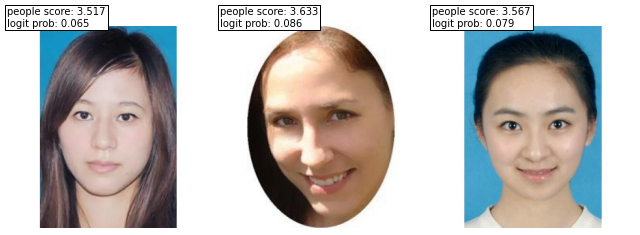

In [13]:
# naive transform: prob * 4 + 1 -> [1..5] scores range
scores_logit = preds_logit * 4 + 1
scores_logit_diff = np.abs(scores_logit - y_test)

diverge_ids = scores_logit_diff.argsort()[:-4:-1]
diverge_images = []
diverge_scores = []

for idx, (img, score) in enumerate(scores_test.items()):
    img_path = os.path.join(IMAGES_PATH, img)
    if idx in diverge_ids:
        diverge_images.append(Image.open(img_path))
        diverge_scores.append((score, preds_logit[idx]))

fig, ax = plt.subplots(1, 3, figsize=(9, 9))
for idx, img in enumerate(diverge_images):
    ax[idx].axis('off')
    ax[idx].imshow(img)
    dscore = diverge_scores[idx]
    ax[idx].text(0, 0, f'people score: {dscore[0]:.3f}\nlogit prob: {dscore[1]:.3f}',  bbox={'facecolor': 'white', 'pad': 2})
fig.tight_layout()

#### CLIP zero shot (learning?)

In [14]:
# sigmoid over dot product
clip_scores = (DOT_PRODUCT_SCALE * X_test @ text_features.T).sigmoid().squeeze().cpu().numpy()

print(clip_scores.shape)
print(clip_scores.mean(), clip_scores.std())

(1077,)
0.5462767 0.003124947


In [15]:
print(f'CLIP ROC AUC = {roc_auc_score(y_test_cat, clip_scores):.3f}')

CLIP ROC AUC = 0.843


#### Lets visualise 9 photos with heights and lowest score

In [16]:
beautiful_ids = clip_scores.argsort()[:-10:-1]
ugly_ids = clip_scores.argsort()[:9]

In [17]:
beautiful = []
ugly = []

for idx, (img, score) in enumerate(scores_test.items()):
    img_path = f'./data/images/{img}'
    if idx in beautiful_ids:
        beautiful.append(Image.open(img_path))
    elif idx in ugly_ids:
        ugly.append(Image.open(img_path))

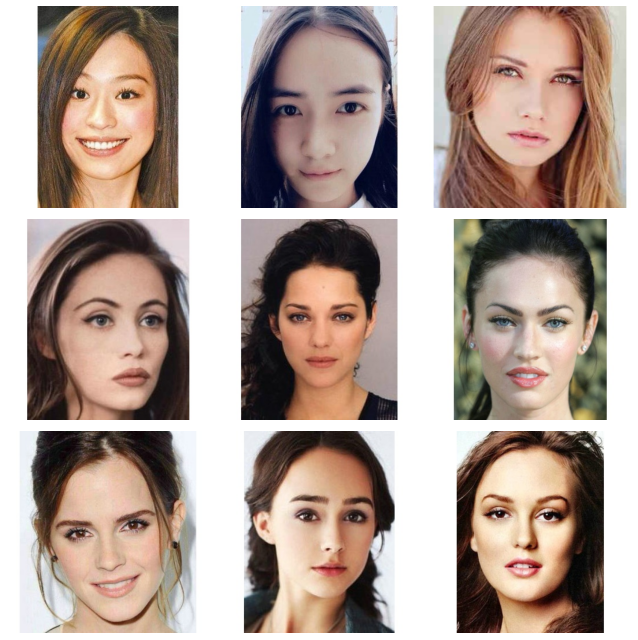

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for idx, img in enumerate(beautiful):
    ax[idx // 3, idx % 3].axis('off')
    ax[idx // 3, idx % 3].imshow(img)
fig.tight_layout()

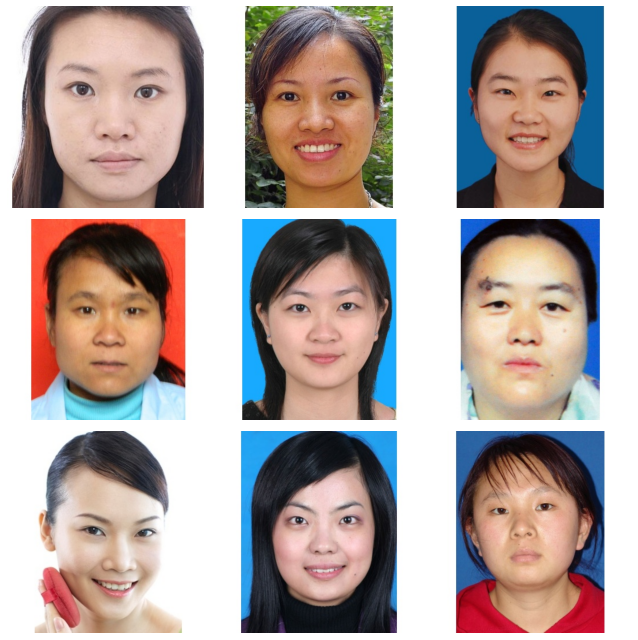

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for idx, img in enumerate(ugly):
    ax[idx // 3, idx % 3].axis('off')
    ax[idx // 3, idx % 3].imshow(img)
fig.tight_layout()

#### Analysis of text prompt

Let's find out how score depends on prompt text

In [20]:
prompt_texts = [
    'a photo of a beautiful woman',  # default prompt with synonyms for "beautiful"
    'a photo of an attractive woman',
    'a photo of a pretty woman',
    'a photo of a good-looking woman',
    'beautiful woman',  # removing "a photo of"
    'attractive woman',
    'pretty woman',
    'good-looking woman',
    'a photo of a beautiful person',  # replace "woman" with "person"
    'a photo of an attractive person',
    'a photo of a pretty person',
    'a photo of a good-looking person',
    'a photo of a beautiful female',  # replace "woman" with "female"
    'a photo of an attractive female',
    'a photo of a pretty female',
    'a photo of a good-looking female',
    'a photo of a beautiful girl',  # some more synonyms 
    'a photo of a beautiful lady',
    'a photo of a model',
    'a foto beautifull woman',  # grammatical mistakes
]

texts = clip.tokenize(prompt_texts).to(device)

with torch.no_grad():
    texts_features = model.encode_text(texts)

texts_features /= texts_features.norm(dim=-1, keepdim=True)
print(texts_features.shape)

torch.Size([20, 1024])


In [21]:
clip_scores_train = (10 * X_train @ texts_features.T).sigmoid().squeeze().cpu().numpy()
print(clip_scores_train.shape, clip_scores_train.mean(), clip_scores_train.std())

(1673, 20) 0.8610208 0.025688736


In [22]:
# calculate mean score per text prompt
prompt_mean = clip_scores_train.mean(axis=0)
prompt_std = clip_scores_train.std(axis=0)

In [23]:
df_clip_scores = pd.DataFrame(clip_scores_train, columns=prompt_texts)
sorted_order = [prompt_texts[i] for i in np.argsort(prompt_mean)]

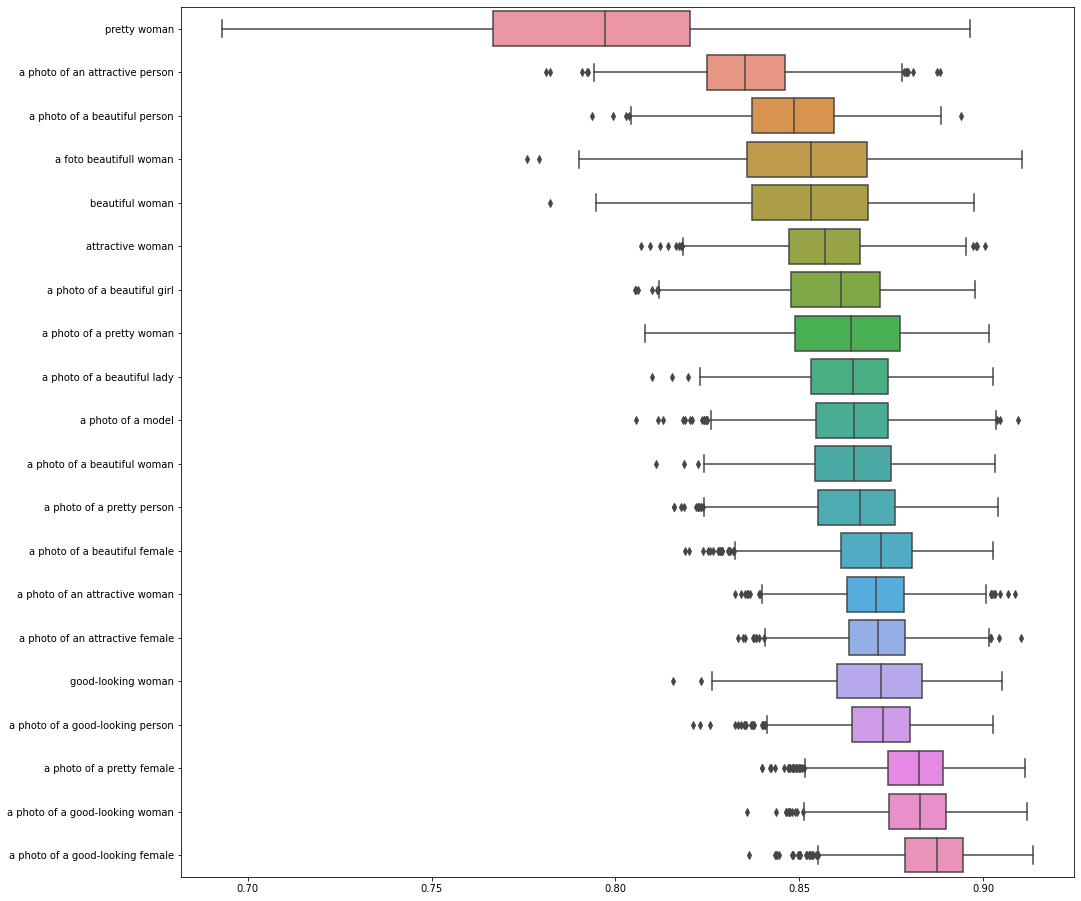

In [24]:
plt.figure(figsize=(16, 16))
ax = sns.boxplot(data=df_clip_scores, orient='h', order=sorted_order)
plt.yticks(plt.yticks()[0], sorted_order);

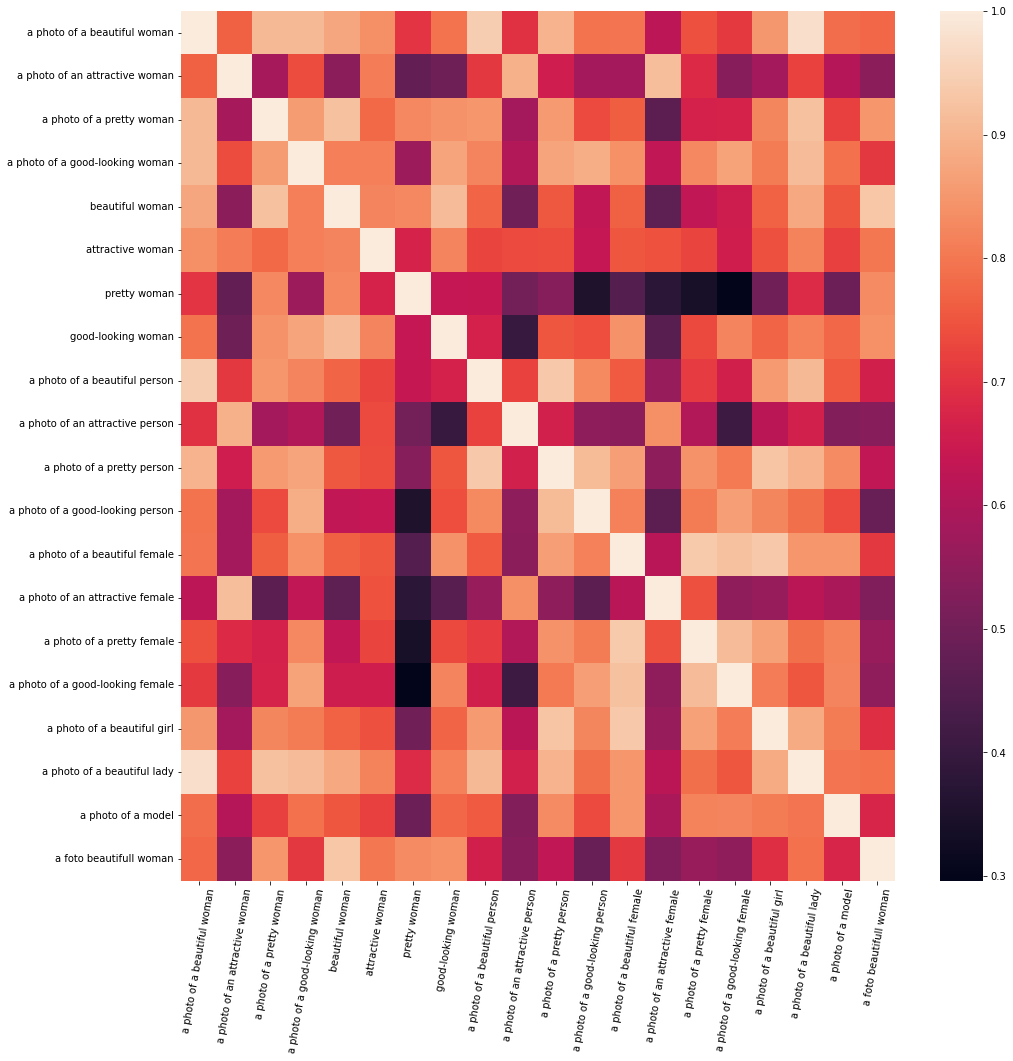

In [25]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(df_clip_scores.corr());
ax.tick_params(axis='x', rotation=80)

Looks OK-ish to me


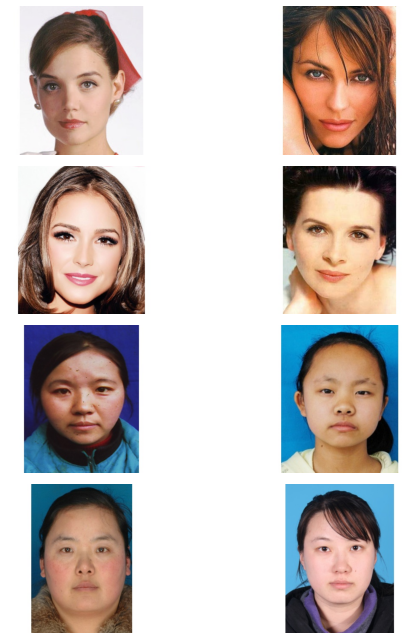

In [26]:
# "pretty woman" looks strange, lets visualize 4 images with highest and lowest score
beautiful_ids = df_clip_scores['pretty woman'].values.argsort()[:-5:-1]
ugly_ids = df_clip_scores['pretty woman'].values.argsort()[:4]

beautiful = []
ugly = []

for idx, (img, score) in enumerate(scores_train.items()):
    img_path = f'./data/images/{img}'
    if idx in beautiful_ids:
        beautiful.append(Image.open(img_path))
    elif idx in ugly_ids:
        ugly.append(Image.open(img_path))

fig, ax = plt.subplots(4, 2, figsize=(9, 9))
for idx, img in enumerate(beautiful):
    ax[idx // 2, idx % 2].axis('off')
    ax[idx // 2, idx % 2].imshow(img)

for idx, img in enumerate(ugly):
    ax[2 + idx // 2, idx % 2].axis('off')
    ax[2 + idx // 2, idx % 2].imshow(img)
fig.tight_layout()
print('Looks OK-ish to me')

## Clip guided image (?) RGB (?) transfer

Didn't work out, possible reasons:
- implementation errors
- hyperparameters and loss tuning are required
- doing the task in RGB-space was a bad idea in the first place (e.g. better use stylegan)

In [27]:
LOSS_TV_WEIGHT = 0.01
LOSS_RANGE_WEIGHT = 20
LR = 1e-2

In [28]:
def reverse_preprocess(img):
    result = np.transpose(np.array(img.numpy()), (1, 2, 0))
    result *= np.array([0.26862954, 0.26130258, 0.27577711])
    result += np.array([0.48145466, 0.4578275, 0.40821073])
    return np.clip(result, 0.0, 1.0)

def draw_diff(start_copy, end_copy):
    diff = np.abs(start_copy - end_copy)
    diff = diff / (diff.max() + 1e-6)
    plt.imshow(diff)

def range_loss(input):
    #taken from this colab https://colab.research.google.com/drive/1QBsaDAZv8np29FPbvjffbE1eytoJcsgA#scrollTo=YHOj78Yvx8jP
    return (input - input.clamp(-2, 2)).pow(2).mean([1, 2, 3])

def tv_loss(input):
    #taken from this colab https://colab.research.google.com/drive/1QBsaDAZv8np29FPbvjffbE1eytoJcsgA#scrollTo=YHOj78Yvx8jP
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])

torch.Size([1, 3, 224, 224])


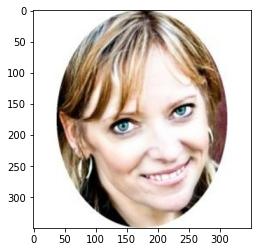

In [29]:
test_img_path = f'./data/images/{"C" if np.random.rand() > 0.5 else "A"}F{np.random.randint(0, 150)}.jpg'
test_img = Image.open(test_img_path)
plt.imshow(test_img)

test_img = preprocess(test_img).unsqueeze(0)
start_img_copy = np.array(reverse_preprocess(test_img.detach()[0]))
print(test_img.shape)

In [30]:
text = clip.tokenize('a photo of a beautiful woman').to(device)
with torch.no_grad():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(text_features.shape)

torch.Size([1, 1024])


In [31]:
test_img = test_img.requires_grad_(True)
optimizer = torch.optim.Adam([test_img], lr=LR)
criterion = torch.nn.MSELoss()

In [32]:
for ep in tqdm(range(100)):
    optimizer.zero_grad()
    
    img_features = model.encode_image(test_img)
    img_features = img_features / img_features.norm(dim=-1, keepdim=True)

    loss = criterion(img_features, text_features) ** 0.5 * 1.0
#     loss = -((img_features * text_features).sum() ** 0.5) * 1.0
    loss += range_loss(test_img).sum() * LOSS_RANGE_WEIGHT
    loss += tv_loss(test_img).sum() * LOSS_TV_WEIGHT
    if ep % 5 == 0:
        print(f'ep {ep}, loss = {loss.item():.4f}')
    loss.backward()

    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

ep 0, loss = 0.1053
ep 5, loss = 0.0641
ep 10, loss = 0.0448
ep 15, loss = 0.0381
ep 20, loss = 0.0370
ep 25, loss = 0.0365
ep 30, loss = 0.0361
ep 35, loss = 0.0355
ep 40, loss = 0.0352
ep 45, loss = 0.0349
ep 50, loss = 0.0346
ep 55, loss = 0.0343
ep 60, loss = 0.0340
ep 65, loss = 0.0339
ep 70, loss = 0.0336
ep 75, loss = 0.0333
ep 80, loss = 0.0332
ep 85, loss = 0.0330
ep 90, loss = 0.0327
ep 95, loss = 0.0327


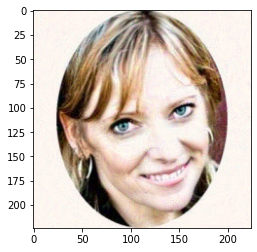

In [33]:
end_img_copy = np.array(reverse_preprocess(test_img.detach()[0]))
plt.imshow(reverse_preprocess(test_img.detach()[0]));

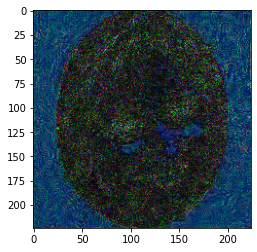

In [34]:
draw_diff(start_img_copy, end_img_copy)

result looks unpromising 